In [1]:
# Austin Griffith
# Simple Portfolio Optimization
# Python 3.6.3
# 1/17/2018

import pandas as pd
import numpy as np
from gurobipy import *
import math
import os
import matplotlib.pyplot as plt

# create directory for graphs
name = 'data'
if os.path.exists(name) == False:
    os.makedirs(name)

In [3]:
# read in monthly returns data
ret = pd.read_csv('monthly_returns.csv')
ret = ret.set_index('Unnamed: 0')
ret = ret.reset_index(drop=True)

# summary statistics of the data
avg = ret.mean()
std = ret.std()
cov = ret.cov()

In [4]:
# outputting average and std deviation of returns
# and covariance matrix
print('Average Returns')
print(avg)
print('\nStd Deviation of Returns')
print(std)
print('\nCovariance Matrix of Returns')
print(cov)

Average Returns
AAP     -0.036482
ABBV     0.013259
ABT      0.005762
ACN      0.011961
AGN     -0.028647
AIG     -0.000517
ALL      0.017382
AMGN    -0.000858
AMZN     0.021569
AXP      0.009636
BA       0.023581
BAC      0.015761
BIIB    -0.003504
BK       0.005610
BLK      0.008254
BMY     -0.001813
C        0.007040
CAT      0.026971
CELG    -0.012224
CL       0.002211
CMCSA    0.004886
COF      0.001393
COP      0.000468
COST     0.001792
CSCO     0.008188
CVS     -0.015707
CVX      0.006716
DHR      0.009700
DIS     -0.008288
DUK      0.011002
           ...   
NEE      0.020440
NKE     -0.009779
ORCL     0.010668
OXY     -0.004581
PCLN     0.008946
PEP      0.005372
PFE     -0.000828
PG       0.002705
PM       0.007130
PYPL     0.029514
QCOM    -0.002458
RTN      0.017942
SBUX    -0.005627
SLB     -0.008130
SO       0.007814
SPG     -0.015100
T        0.000045
TGT     -0.011951
TWX      0.006435
TXN      0.023851
UNH      0.018977
UNP      0.009910
UPS      0.005439
USB      0.0

In [5]:
# create new model for the minimum risk portfolio
model = Model('min_risk')

# labels and variables for each stock
tickers = ret.columns
variables = pd.Series(model.addVars(tickers),index=tickers)

# determine the risk using the covariance matrix
port_risk = cov.dot(variables).dot(variables)

In [6]:
# set the model to minimize
model.setObjective(port_risk,GRB.MINIMIZE)

# constraints
# weights add up to 1
model.addConstr(variables.sum() == 1,'weights')
model.update()
# no shorting stocks(w >= 0)
model.setParam('OutputFlag',0)
model.update()

# optimize model, finds minimum risk portfolio with constraints
model.optimize()

In [7]:
# display variables and respective weights
n = 0
weights = {}
for v in variables:
    weights.update({tickers[n]:v.x})
    n = n + 1
weights = pd.DataFrame([weights])
weights = weights.transpose()
weights.columns = ['Weights']

print('\nMin Risk, Optimal Weights Per Stock')
print(weights['Weights'])


Min Risk, Optimal Weights Per Stock
AAP      4.343957e-10
ABBV     1.753619e-08
ABT      1.174487e-09
ACN      1.052026e-09
AGN      1.113264e-09
AIG      1.903681e-09
ALL      1.706651e-09
AMGN     8.175485e-10
AMZN     4.858564e-02
AXP      9.297517e-10
BA       5.188628e-10
BAC      8.874728e-10
BIIB     5.101854e-03
BK       5.093181e-09
BLK      1.200605e-09
BMY      1.657536e-09
C        1.313113e-09
CAT      7.679085e-10
CELG     1.333203e-09
CL       1.480187e-09
CMCSA    7.042930e-10
COF      8.189786e-10
COP      6.262754e-10
COST     5.970193e-10
CSCO     7.359070e-10
CVS      1.450792e-09
CVX      1.221077e-09
DHR      3.729140e-09
DIS      9.045728e-10
DUK      2.262880e-09
             ...     
NEE      1.751008e-08
NKE      2.557498e-09
ORCL     1.707398e-09
OXY      1.300130e-01
PCLN     4.868043e-10
PEP      1.966735e-09
PFE      1.421174e-09
PG       1.427569e-01
PM       8.326598e-10
PYPL     1.031476e-01
QCOM     1.753294e-09
RTN      1.596432e-04
SBUX     6.363715

In [8]:
# organize dataframes
main = pd.concat([avg,std,weights],axis=1)
main.columns = ['Avg','Std','Weights']

# save values to csv
cov.to_csv(name+'/CovarianceRet.csv')
main.to_csv(name+'/MinRiskPort.csv')

In [9]:
# minimum risk values
# optimal objective value
print('\nMinimized Portfolio Variance : '+str(port_risk.getValue()))
# volatility
min_vol = math.sqrt(port_risk.getValue())
print('Volatility : '+str(min_vol))
# expected return using optimized weights
port_return = avg.dot(variables)
Rmin = port_return.getValue()
print('Expected Return (Rmin) : '+str(Rmin))


Minimized Portfolio Variance : 4.549554297811946e-05
Volatility : 0.006745038397082663
Expected Return (Rmin) : 0.0014659021111393478


In [10]:
# maximum return value among all stocks
Rmax = avg.max()

# return constraint
target = model.addConstr(port_return == Rmin, 'target')

# calculate values of efficient frontier
# set right hand side of target value for returns
# iterate through the range of returns from Rmin to Rmax
eff = {}
iterations = 50
diff = (Rmax-Rmin)/(iterations-1)
Rrange = np.arange(Rmin,Rmax+diff,diff)
for r in Rrange:
    target.rhs = r
    model.optimize()
    temp = math.sqrt(port_risk.getValue())
    eff.update({temp:r})

# organize dataframe for efficient frontier
frontier = pd.DataFrame([eff]).transpose()
frontier.columns = ['Returns']
frontier['Risk'] = frontier.index
frontier = frontier.reset_index(drop=True)

# output and save values of efficient frontier
print('\nEfficient Frontier')
print(frontier)
frontier.to_csv(name+'/EffFrontier.csv')


Efficient Frontier
     Returns      Risk
0   0.001466  0.006745
1   0.002094  0.006753
2   0.002723  0.006774
3   0.003351  0.006807
4   0.003980  0.006852
5   0.004608  0.006920
6   0.005237  0.007036
7   0.005865  0.007189
8   0.006494  0.007375
9   0.007122  0.007604
10  0.007751  0.007870
11  0.008379  0.008164
12  0.009008  0.008482
13  0.009636  0.008826
14  0.010265  0.009196
15  0.010893  0.009590
16  0.011522  0.009994
17  0.012150  0.010403
18  0.012779  0.010819
19  0.013407  0.011241
20  0.014036  0.011673
21  0.014664  0.012113
22  0.015293  0.012559
23  0.015921  0.013011
24  0.016550  0.013480
25  0.017178  0.013966
26  0.017807  0.014467
27  0.018435  0.014995
28  0.019064  0.015582
29  0.019692  0.016264
30  0.020321  0.017107
31  0.020949  0.018133
32  0.021578  0.019330
33  0.022206  0.020665
34  0.022835  0.022147
35  0.023463  0.023776
36  0.024092  0.025526
37  0.024720  0.027376
38  0.025349  0.029367
39  0.025977  0.031541
40  0.026606  0.033866
41  0.027234  

In [11]:
# retrieve maximum sharpe value along efficient frontier
frontier['Sharpe'] = frontier['Returns']/frontier['Risk']
idx = frontier['Sharpe'].max()
sharpeMax = frontier.loc[frontier['Sharpe'] == idx]
sharpeMax = sharpeMax.reset_index(drop=True)

# find max sharpe weights
target.rhs = sharpeMax['Returns'][0]
model.optimize()
n = 0
sharpe_weights = {}
for v in variables:
    sharpe_weights.update({tickers[n]:v.x})
    n = n + 1
sharpe_weights = pd.DataFrame([sharpe_weights])
sharpe_weights = sharpe_weights.transpose()
sharpe_weights.columns = ['Weights']

# display and save max sharpe values
print('\nMaximum Sharpe Ratio')
print(sharpeMax)
print(sharpe_weights)
sharpe_weights.to_csv(name+'/MaxSharpeWeights.csv')


Maximum Sharpe Ratio
    Returns      Risk    Sharpe
0  0.017807  0.014467  1.230851
            Weights
AAP    3.088171e-08
ABBV   1.974417e-02
ABT    5.843558e-08
ACN    7.759169e-08
AGN    4.503692e-08
AIG    1.003213e-07
ALL    4.819387e-02
AMGN   4.925627e-08
AMZN   9.266086e-02
AXP    1.510912e-07
BA     6.463117e-08
BAC    1.669594e-07
BIIB   6.919730e-08
BK     1.141673e-02
BLK    8.197114e-08
BMY    3.309634e-08
C      1.192010e-07
CAT    2.107200e-07
CELG   1.187137e-07
CL     9.281109e-08
CMCSA  9.938476e-08
COF    6.923450e-08
COP    7.701226e-08
COST   5.613513e-08
CSCO   3.932335e-07
CVS    1.371708e-07
CVX    2.013721e-07
DHR    1.476083e-06
DIS    1.289603e-07
DUK    1.186922e-07
...             ...
NEE    2.067558e-01
NKE    7.392627e-08
ORCL   5.170692e-07
OXY    6.080696e-07
PCLN   2.276246e-07
PEP    1.366525e-07
PFE    7.192188e-08
PG     3.307076e-06
PM     1.671758e-07
PYPL   9.765230e-02
QCOM   1.012629e-07
RTN    1.814510e-01
SBUX   7.613104e-08
SLB    1.46823

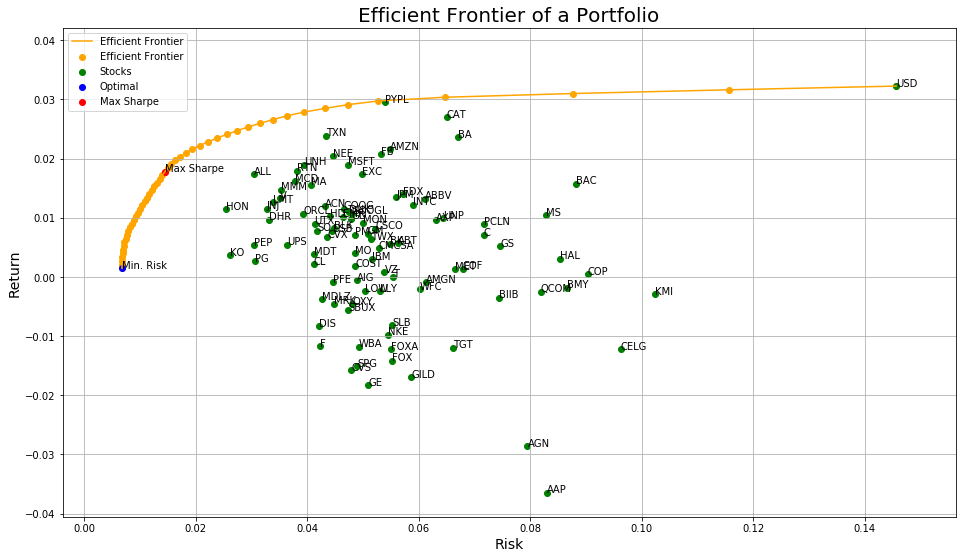

In [12]:
# plot of the efficient frontier from Rmin to Rmax
# initialize plot, set labels
fig, ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(16,9)
ax.set_title('Efficient Frontier of a Portfolio',fontsize=20)
ax.set_xlabel('Risk',fontsize=14)
ax.set_ylabel('Return',fontsize=14)

# plot the efficient frontier
# do this first to allow individual points later on to overlay
ax.scatter(x=frontier['Risk'],y=frontier['Returns'],color='orange',label='Efficient Frontier')
ax.plot(x=frontier['Risk'],y=frontier['Returns'],color='orange')
temp = pd.DataFrame([eff]).transpose()
temp.columns = ['Efficient Frontier']
temp.plot(color='orange',label='Efficient Frontier',ax=ax)

# average return/volatility for each individual stock
ax.scatter(x=std,y=avg,color='green',label='Stocks')
i = 0
for stock in tickers:
    ax.annotate(stock,(std[i],avg[i]))
    i = i + 1

# show the minimum risk portfolio
ax.scatter(x=min_vol,y=Rmin,color='blue',label='Optimal')
ax.annotate('Min. Risk',(min_vol,Rmin))

# show maximum sharpe value
ax.scatter(x=sharpeMax['Risk'],y=sharpeMax['Returns'],color='red',label='Max Sharpe')
ax.annotate('Max Sharpe',(sharpeMax['Risk'],sharpeMax['Returns']))

# additional edits to the graph
ax.grid()
ax.legend(loc='upper left')
fig.savefig(name+'/EfficientFrontier.png')